In [6]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [9]:
data, dataName = loadData.loadData("all_all.csv")


 Total trials before cleaning
: 29177
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 24471


In [10]:
intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"
#s
visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)
print("Visual test duration range:", data["recordedDurVisualTest"].min(), "to", data["recordedDurVisualTest"].max())
print("t_min, t_max:", mc_fitter.t_min, mc_fitter.t_max)

Visual test duration range: 0.0238 to 1.2582
t_min, t_max: 0.0249 0.99539


# Fit data

In [11]:
# fit parameters
mc_fitter.nSimul = 100
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.modelName = "logLinearMismatch"  # Set measurement distribution to Gaussian

# If not fitted load fitted parameters

In [12]:
# read back the saved file to verify

import os
import json
import loadResults
try:
    res=loadResults.loadFitResults(dataName, modelName=mc_fitter.modelName)
    print(f"Loaded saved fit results: {res}")
    mc_fitter.modelFit= res['fittedParams']
    mc_fitter.logLikelihood= res['logLikelihood']
    mc_fitter.aic= res['AIC']
    mc_fitter.bic= res['BIC']
    mc_fitter.nDataPoints= res['n_conditions']
except:
    print("No saved fit results found, proceeding to fit the model.")
    timeStart = time.time()
    print(f"\nFitting Causal Inference Model for {dataName} with {len(mc_fitter.groupedData)} unique conditions")
    fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(mc_fitter.groupedData)
    print(f"\nFitted parameters for {dataName}: {fittedParams}")
    print(f"Time taken to fit: {time.time() - timeStart:.2f} seconds")
    mc_fitter.modelFit= fittedParams
    mc_fitter.logLikelihood= -mc_fitter.nLLMonteCarloCausal(fittedParams, mc_fitter.groupedData)    
    #save the fit results
    

Loaded saved fit results: {'participantID': 'all', 'modelType': 'logLinearMismatch', 'fittedParams': [0.13004470634332393, 0.2542544832074781, 0.5066494413220789, 0.9999858324206901, 0.6159969235025347, 0.5066494413220789], 'AIC': 27112.839142851393, 'BIC': 27152.752633385848, 'logLikelihood': -13550.419571425697, 'n_conditions': 5723}


## Simulate data using fitted parameters

In [13]:
mc_fitter.simulatedData = mc_fitter.simulateMonteCarloData(mc_fitter.modelFit, mc_fitter.data, nSamples=100)
mc_fitter.simDataFit=mc_fitter.fitMultipleStartingPoints(mc_fitter.simulatedData,1)

"psychometric fit"
mc_fitter.dataFit= mc_fitter.fitMultipleStartingPoints(data,1)

# Plot the fits

Plotting psychometric curves for Monte Carlo model and data...
Noise: 0.1, Conflict: -0.25, Lambda: 0.507, Sigma_a: 0.254, Sigma_v: 0.507, p_c: 1.000
Noise: 0.1, Conflict: -0.17, Lambda: 0.130, Sigma_a: 0.254, Sigma_v: 0.507, p_c: 1.000
Noise: 0.1, Conflict: -0.08, Lambda: 0.616, Sigma_a: 0.254, Sigma_v: 0.507, p_c: 1.000
Noise: 0.1, Conflict: 0.0, Lambda: 0.130, Sigma_a: 0.254, Sigma_v: 0.507, p_c: 1.000
Noise: 0.1, Conflict: 0.08, Lambda: 0.507, Sigma_a: 0.254, Sigma_v: 0.507, p_c: 1.000
Noise: 0.1, Conflict: 0.17, Lambda: 0.616, Sigma_a: 0.254, Sigma_v: 0.507, p_c: 1.000
Noise: 0.1, Conflict: 0.25, Lambda: 0.130, Sigma_a: 0.254, Sigma_v: 0.507, p_c: 1.000
Noise: 1.2, Conflict: -0.25, Lambda: 0.507, Sigma_a: 0.616, Sigma_v: 0.507, p_c: 1.000
Noise: 1.2, Conflict: -0.17, Lambda: 0.130, Sigma_a: 0.616, Sigma_v: 0.507, p_c: 1.000
Noise: 1.2, Conflict: -0.08, Lambda: 0.616, Sigma_a: 0.616, Sigma_v: 0.507, p_c: 1.000
Noise: 1.2, Conflict: 0.0, Lambda: 0.130, Sigma_a: 0.616, Sigma_v: 0.507

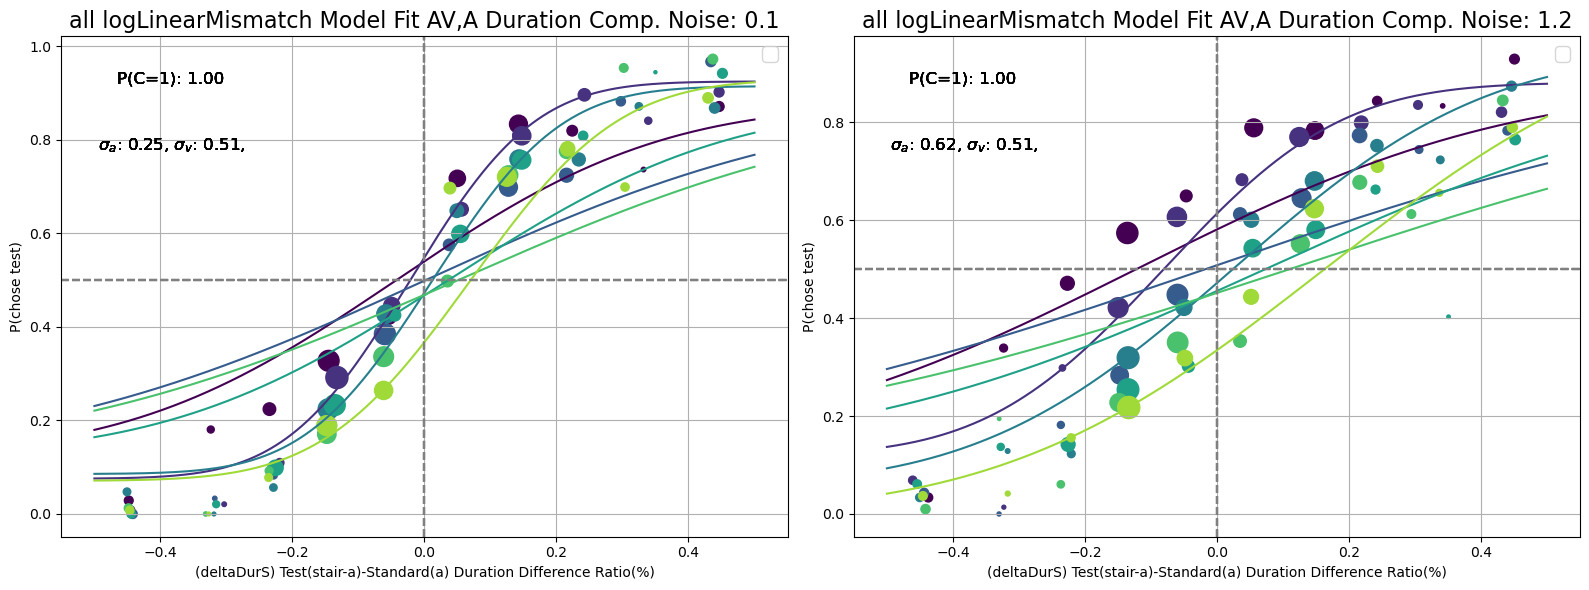

In [14]:
# from importlib import reload
# reload(monteCarloClass)
# import monteCarloClass
mc_fitter.dataName = dataName.split('_')[0]

mc_fitter.plotPsychometrics_MC_Data()

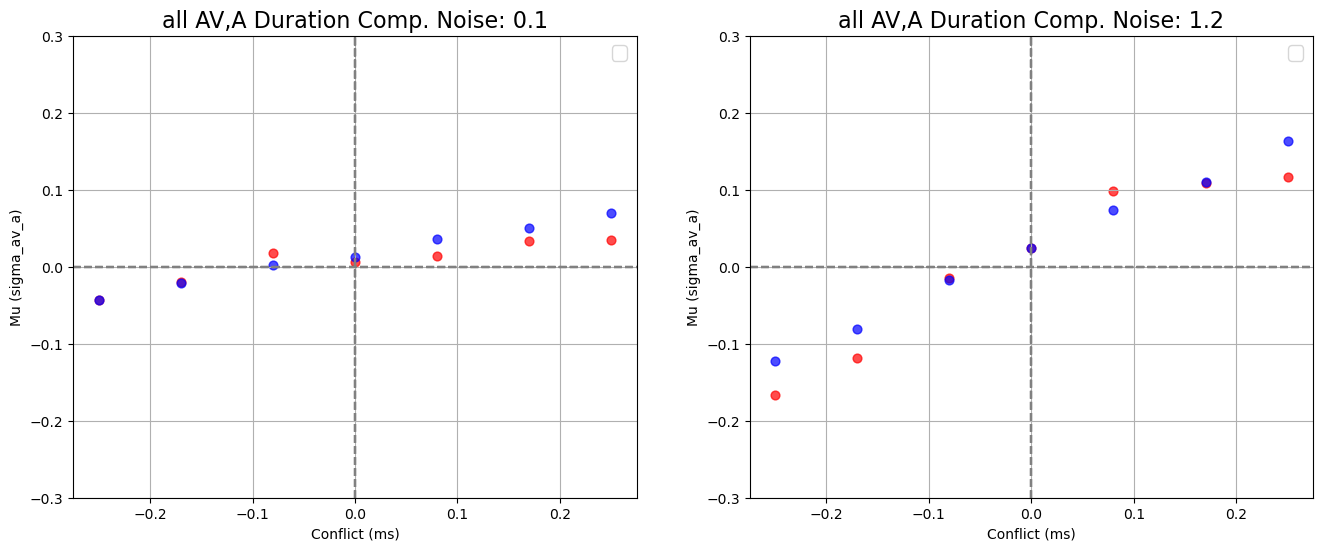

In [15]:
mc_fitter.plot_mu_vs_conflict_MC_vs_Data()

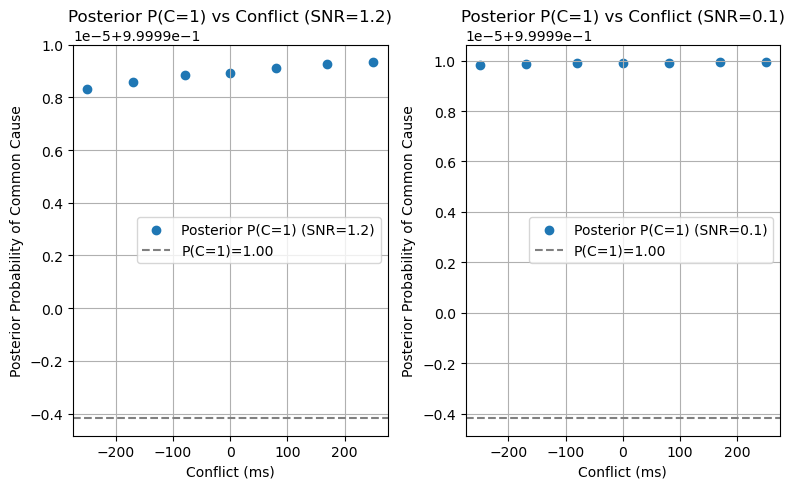

In [16]:
fittedParams = mc_fitter.modelFit
mc_fitter.plot_posterior_vs_conflict(mc_fitter.data, fittedParams)

# Model Comparison Analysis

Now let's create comprehensive tables to compare all model fits across participants.

In [ ]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)
    
    for file_path in json_files:
        # if in filename "all_all", skip
        if "all" in os.path.basename(file_path):
            continue
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            if 'modelType' not in result:
                result['modelType'] = '_'.join(parts[1:])
                
            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}")

Loaded 36 model fit results
Participants: ['HH', 'LN01', 'as', 'dt', 'ip', 'ln', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
Models: ['gaussian', 'logLinearMismatch', 'lognorm']


In [ ]:
# Create comprehensive comparison table
def create_model_comparison_table(df_results):
    """Create a detailed comparison table of all model fits"""
    
    # Pivot table to compare models side by side
    comparison_cols = ['AIC', 'BIC', 'logLikelihood', 'n_conditions']
    
    summary_table = df_results.pivot_table(
        index='participantID', 
        columns='modelType', 
        values=comparison_cols,
        aggfunc='first'
    )
    
    return summary_table

# Create the comparison table
comparison_table = create_model_comparison_table(df_results)
print("Model Comparison Table:")
print("=" * 80)
print(comparison_table.round(3))

Model Comparison Table:
                    AIC                                   BIC  \
modelType      gaussian logLinearMismatch   lognorm  gaussian   
participantID                                                   
HH             1831.122          1757.862  1753.087  1855.335   
LN01           1146.468          1177.451  1169.125  1169.226   
as             2253.686          2255.068  2253.682  2277.971   
dt             2550.741          2551.461  2552.001  2575.302   
ip             2461.031          2408.125  2410.175  2486.234   
ln             2187.497          2165.144  2170.786  2212.540   
mh             2493.782          2441.444  2444.386  2519.021   
ml             2506.142          2547.098  2533.774  2532.534   
mt             2228.041          2220.817  2216.817  2251.324   
oy             2340.533          2325.039  2328.285  2367.612   
qs             2529.395          2504.177  2501.248  2554.524   
sx             2146.469          2178.170  2178.113  2172.015   



In [ ]:
# Find best model for each participant (lowest AIC)
def find_best_models(df_results):
    """Find the best fitting model for each participant based on AIC"""
    best_models = []
    
    for participant in df_results['participantID'].unique():
        participant_data = df_results[df_results['participantID'] == participant]
        
        if len(participant_data) > 0:
            # Find model with lowest AIC
            best_idx = participant_data['AIC'].idxmin()
            best_model = participant_data.loc[best_idx]
            
            best_models.append({
                'participantID': participant,
                'best_model': best_model['modelType'],
                'AIC': best_model['AIC'],
                'BIC': best_model['BIC'],
                'logLikelihood': best_model['logLikelihood']
            })
    
    return pd.DataFrame(best_models)

# Find best models
best_models_df = find_best_models(df_results)
print("\nBest Model for Each Participant (based on AIC):")
print("=" * 60)
print(best_models_df.round(3))

# Model performance summary
print(f"\nModel Performance Summary:")
print("=" * 40)
model_counts = best_models_df['best_model'].value_counts()
for model, count in model_counts.items():
    percentage = (count / len(best_models_df)) * 100
    print(f"{model}: {count} participants ({percentage:.1f}%)")


Best Model for Each Participant (based on AIC):
   participantID         best_model       AIC       BIC  logLikelihood
0             sx           gaussian  2146.469  2172.015      -1067.234
1             mt            lognorm  2216.817  2240.100      -1102.408
2             mh  logLinearMismatch  2441.444  2466.684      -1214.722
3             dt           gaussian  2550.741  2575.302      -1269.370
4             oy  logLinearMismatch  2325.039  2352.118      -1156.519
5             qs            lognorm  2501.248  2526.377      -1244.624
6             ml           gaussian  2506.142  2532.534      -1247.071
7             HH            lognorm  1753.087  1777.300       -870.544
8             as            lognorm  2253.682  2277.966      -1120.841
9             ln  logLinearMismatch  2165.144  2190.186      -1076.572
10            ip  logLinearMismatch  2408.125  2433.328      -1198.063
11          LN01           gaussian  1146.468  1169.226       -567.234

Model Performance Summary:


In [ ]:
# Create parameter comparison table
def create_parameter_table(df_results):
    """Create a table showing fitted parameters for each model and participant"""
    param_data = []
    
    for _, row in df_results.iterrows():
        params = row['fittedParams']
        if isinstance(params, list) and len(params) >= 4:
            param_data.append({
                'participantID': row['participantID'],
                'modelType': row['modelType'],
                'lambda': params[0] if len(params) > 0 else None,
                'sigma_av_a_low': params[1] if len(params) > 1 else None,
                'sigma_av_v_low': params[2] if len(params) > 2 else None,
                'p_c': params[3] if len(params) > 3 else None,
                'sigma_av_a_high': params[4] if len(params) > 4 else None,
                'sigma_av_v_high': params[5] if len(params) > 5 else None,
                'AIC': row['AIC'],
                'BIC': row['BIC']
            })
    
    return pd.DataFrame(param_data)

# Create parameter table
param_table = create_parameter_table(df_results)
print("\nFitted Parameters Summary:")
print("=" * 80)
print(param_table.round(4))


Fitted Parameters Summary:
   participantID          modelType  lambda  sigma_av_a_low  sigma_av_v_low  \
0             sx            lognorm  0.0206          0.7793          0.3386   
1             sx           gaussian  0.0226          0.2262          0.1549   
2             sx  logLinearMismatch  0.0502          0.5032          0.3240   
3             mt  logLinearMismatch  0.0736          0.1799          0.4595   
4             mt            lognorm  0.0751          0.1902          0.2966   
5             mt           gaussian  0.0625          0.1000          0.2289   
6             mh  logLinearMismatch  0.1156          0.5395          0.5220   
7             mh            lognorm  0.1454          0.4950          0.4875   
8             mh           gaussian  0.1658          0.2714          0.2342   
9             dt           gaussian  0.2193          0.1038          0.2351   
10            dt            lognorm  0.2548          0.2106          0.3220   
11            dt  logLin

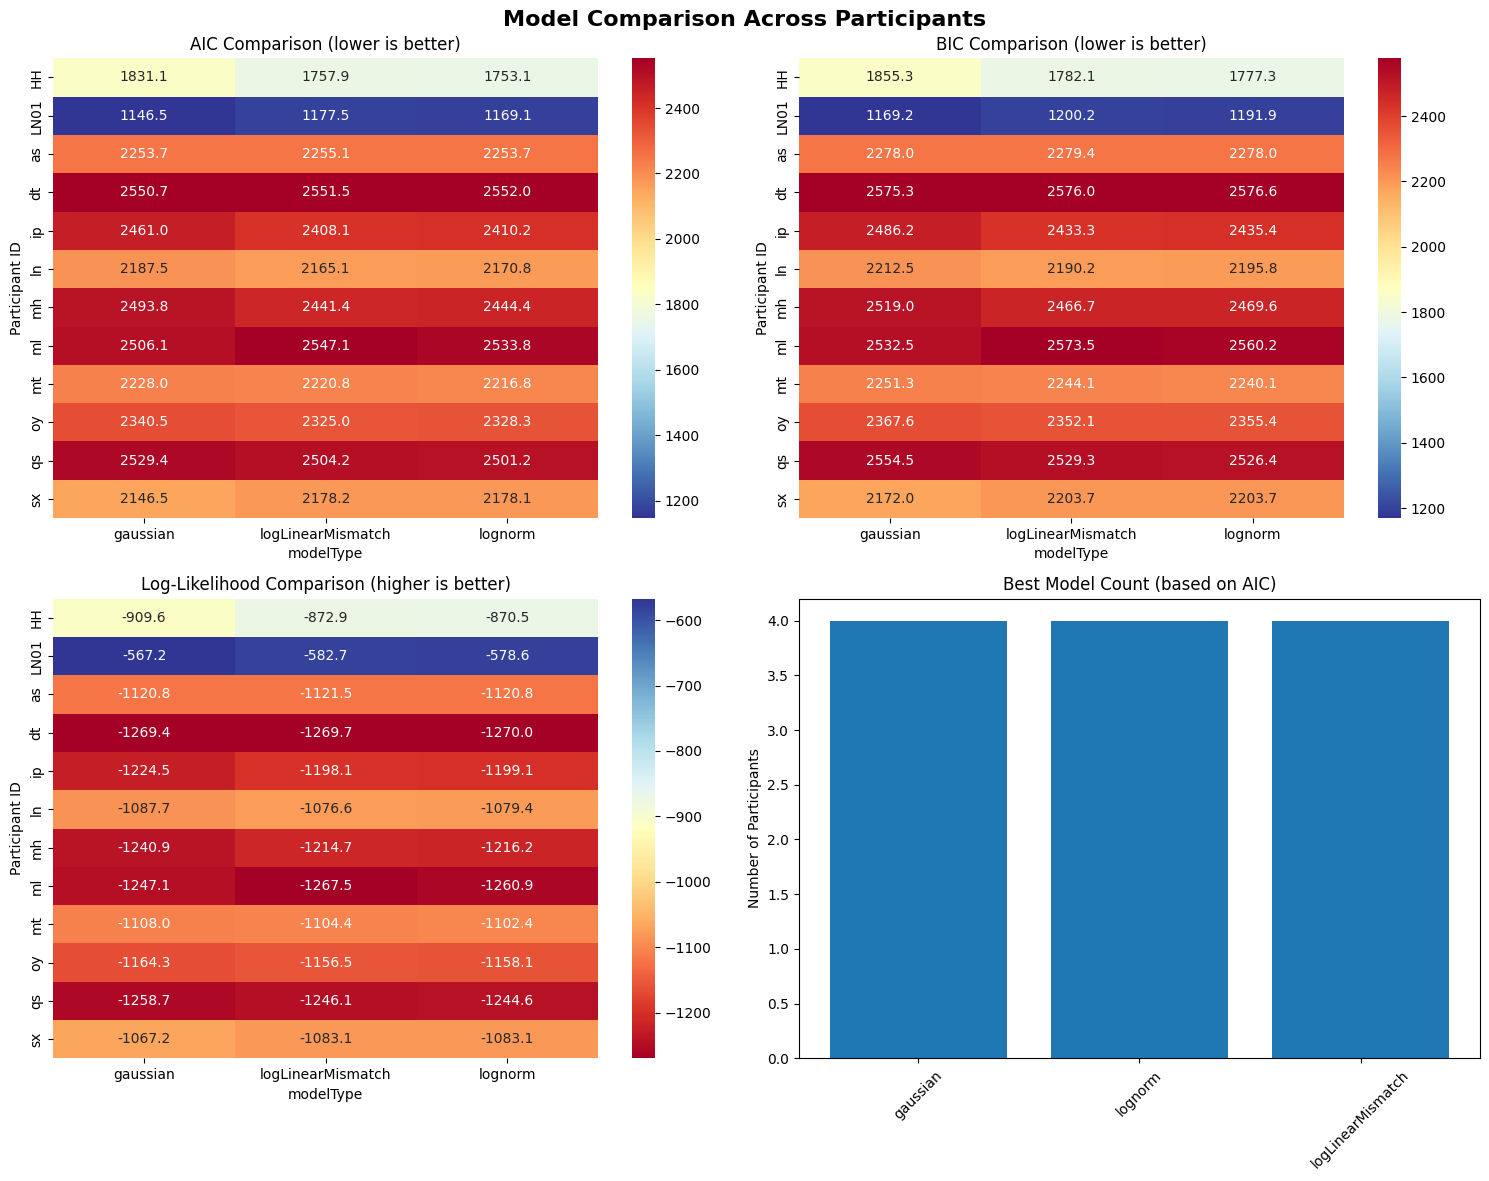

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create visualizations for model comparison
def plot_model_comparison(df_results):
    """Create plots comparing model performance"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Comparison Across Participants', fontsize=16, fontweight='bold')
    
    # 1. AIC comparison
    df_aic = df_results.pivot(index='participantID', columns='modelType', values='AIC')
    sns.heatmap(df_aic, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=axes[0,0])
    axes[0,0].set_title('AIC Comparison (lower is better)')
    axes[0,0].set_ylabel('Participant ID')
    
    # 2. BIC comparison
    df_bic = df_results.pivot(index='participantID', columns='modelType', values='BIC')
    sns.heatmap(df_bic, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=axes[0,1])
    axes[0,1].set_title('BIC Comparison (lower is better)')
    axes[0,1].set_ylabel('Participant ID')
    
    # 3. Log-likelihood comparison
    df_ll = df_results.pivot(index='participantID', columns='modelType', values='logLikelihood')
    sns.heatmap(df_ll, annot=True, fmt='.1f', cmap='RdYlBu', ax=axes[1,0])
    axes[1,0].set_title('Log-Likelihood Comparison (higher is better)')
    axes[1,0].set_ylabel('Participant ID')
    
    # 4. Best model count
    best_model_counts = find_best_models(df_results)['best_model'].value_counts()
    axes[1,1].bar(best_model_counts.index, best_model_counts.values)
    axes[1,1].set_title('Best Model Count (based on AIC)')
    axes[1,1].set_ylabel('Number of Participants')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Create the plots
plot_model_comparison(df_results)

In [ ]:
# Save comprehensive results to CSV files
def save_comparison_results(df_results, best_models_df, param_table):
    """Save all comparison results to CSV files"""
    
    # Save main results
    df_results.to_csv('model_comparison_all_results.csv', index=False)
    print("✅ Saved complete results to: model_comparison_all_results.csv")
    
    # Save best models
    best_models_df.to_csv('best_models_by_participant.csv', index=False)
    print("✅ Saved best models to: best_models_by_participant.csv")
    
    # Save parameter table
    param_table.to_csv('fitted_parameters_all_models.csv', index=False)
    print("✅ Saved parameters to: fitted_parameters_all_models.csv")
    
    # Create summary statistics
    summary_stats = {
        'total_participants': len(df_results['participantID'].unique()),
        'total_model_fits': len(df_results),
        'models_tested': list(df_results['modelType'].unique()),
        'best_model_distribution': best_models_df['best_model'].value_counts().to_dict()
    }
    
    # Save summary
    with open('model_comparison_summary.json', 'w') as f:
        json.dump(summary_stats, f, indent=4)
    print("✅ Saved summary statistics to: model_comparison_summary.json")
    
    return summary_stats

# Save all results
summary_stats = save_comparison_results(df_results, best_models_df, param_table)

print(f"\n🎯 SUMMARY STATISTICS:")
print("=" * 50)
print(f"Total participants analyzed: {summary_stats['total_participants']}")
print(f"Total model fits: {summary_stats['total_model_fits']}")
print(f"Models tested: {', '.join(summary_stats['models_tested'])}")
print(f"\nBest model distribution:")
for model, count in summary_stats['best_model_distribution'].items():
    percentage = (count / summary_stats['total_participants']) * 100
    print(f"  {model}: {count} participants ({percentage:.1f}%)")

✅ Saved complete results to: model_comparison_all_results.csv
✅ Saved best models to: best_models_by_participant.csv
✅ Saved parameters to: fitted_parameters_all_models.csv
✅ Saved summary statistics to: model_comparison_summary.json

🎯 SUMMARY STATISTICS:
Total participants analyzed: 12
Total model fits: 36
Models tested: lognorm, gaussian, logLinearMismatch

Best model distribution:
  gaussian: 4 participants (33.3%)
  lognorm: 4 participants (33.3%)
  logLinearMismatch: 4 participants (33.3%)


# Statistical Analysis

Now let's perform comprehensive statistical tests to compare models.

In [ ]:
import scipy.stats as stats
from scipy.stats import chi2

# 1. Likelihood Ratio Tests for Model Comparison
def likelihood_ratio_test(ll_full, ll_reduced, df_diff):
    """
    Perform likelihood ratio test between two nested models
    
    Parameters:
    ll_full: log-likelihood of the more complex model
    ll_reduced: log-likelihood of the simpler model  
    df_diff: difference in degrees of freedom (number of parameters)
    
    Returns:
    LR statistic, p-value, and interpretation
    """
    # Calculate LR statistic
    LR = 2 * (ll_full - ll_reduced)
    
    # Calculate p-value using chi-square distribution
    p_value = 1 - chi2.cdf(LR, df_diff)
    
    # Interpretation
    significant = p_value < 0.05
    
    return {
        'LR_statistic': LR,
        'p_value': p_value,
        'df': df_diff,
        'significant': significant,
        'interpretation': 'Complex model significantly better' if significant else 'Simple model preferred'
    }

# Perform pairwise likelihood ratio tests for each participant
def perform_lr_tests(df_results):
    """Perform all pairwise LR tests for each participant"""
    lr_results = []
    
    participants = df_results['participantID'].unique()
    models = ['gaussian', 'lognorm', 'logLinearMismatch']
    
    for participant in participants:
        p_data = df_results[df_results['participantID'] == participant]
        
        # Get log-likelihoods for each model
        model_lls = {}
        for model in models:
            model_data = p_data[p_data['modelType'] == model]
            if len(model_data) > 0:
                model_lls[model] = model_data.iloc[0]['logLikelihood']
        
        # Perform tests (assuming all models have same number of parameters for simplicity)
        # In practice, you'd need to specify the actual parameter differences
        if len(model_lls) >= 2:
            model_pairs = [
                ('gaussian', 'lognorm', 0),  # Same complexity
                ('gaussian', 'logLinearMismatch', 0),  # Same complexity  
                ('lognorm', 'logLinearMismatch', 0)  # Same complexity
            ]
            
            for model1, model2, df_diff in model_pairs:
                if model1 in model_lls and model2 in model_lls:
                    # Compare models (higher LL is "full" model)
                    if model_lls[model1] >= model_lls[model2]:
                        result = likelihood_ratio_test(model_lls[model1], model_lls[model2], abs(df_diff))
                        better_model = model1
                        worse_model = model2
                    else:
                        result = likelihood_ratio_test(model_lls[model2], model_lls[model1], abs(df_diff))
                        better_model = model2
                        worse_model = model1
                    
                    lr_results.append({
                        'participantID': participant,
                        'model1': model1,
                        'model2': model2,
                        'better_model': better_model,
                        'LR_stat': result['LR_statistic'],
                        'p_value': result['p_value'],
                        'significant': result['significant']
                    })
    
    return pd.DataFrame(lr_results)

# Run LR tests
print("Performing Likelihood Ratio Tests...")
lr_test_results = perform_lr_tests(df_results)
print("\nLikelihood Ratio Test Results:")
print("=" * 80)
print(lr_test_results.round(4))

Performing Likelihood Ratio Tests...

Likelihood Ratio Test Results:
   participantID    model1             model2       better_model  LR_stat  \
0             sx  gaussian            lognorm           gaussian  31.6445   
1             sx  gaussian  logLinearMismatch           gaussian  31.7016   
2             sx   lognorm  logLinearMismatch            lognorm   0.0571   
3             mt  gaussian            lognorm            lognorm  11.2239   
4             mt  gaussian  logLinearMismatch  logLinearMismatch   7.2233   
5             mt   lognorm  logLinearMismatch            lognorm   4.0006   
6             mh  gaussian            lognorm            lognorm  49.3965   
7             mh  gaussian  logLinearMismatch  logLinearMismatch  52.3375   
8             mh   lognorm  logLinearMismatch  logLinearMismatch   2.9410   
9             dt  gaussian            lognorm           gaussian   1.2607   
10            dt  gaussian  logLinearMismatch           gaussian   0.7200   
11     

In [ ]:
# 2. AIC/BIC Difference Analysis
def calculate_model_differences(df_results):
    """Calculate AIC and BIC differences between models"""
    diff_results = []
    
    participants = df_results['participantID'].unique()
    
    for participant in participants:
        p_data = df_results[df_results['participantID'] == participant]
        
        # Get AIC and BIC for each model
        model_metrics = {}
        for _, row in p_data.iterrows():
            model = row['modelType']
            model_metrics[model] = {
                'AIC': row['AIC'],
                'BIC': row['BIC'],
                'logLikelihood': row['logLikelihood']
            }
        
        # Find best model (lowest AIC)
        if model_metrics:
            best_aic_model = min(model_metrics.keys(), key=lambda x: model_metrics[x]['AIC'])
            best_aic = model_metrics[best_aic_model]['AIC']
            
            best_bic_model = min(model_metrics.keys(), key=lambda x: model_metrics[x]['BIC'])
            best_bic = model_metrics[best_bic_model]['BIC']
            
            # Calculate differences from best model
            for model, metrics in model_metrics.items():
                aic_diff = metrics['AIC'] - best_aic
                bic_diff = metrics['BIC'] - best_bic
                
                # AIC interpretation (Burnham & Anderson, 2002)
                if aic_diff == 0:
                    aic_support = "Best model"
                elif aic_diff <= 2:
                    aic_support = "Substantial support"
                elif aic_diff <= 4:
                    aic_support = "Considerable support"  
                elif aic_diff <= 7:
                    aic_support = "Some support"
                else:
                    aic_support = "No support"
                
                # BIC interpretation (Kass & Raftery, 1995)
                if bic_diff == 0:
                    bic_support = "Best model"
                elif bic_diff <= 2:
                    bic_support = "Weak evidence against"
                elif bic_diff <= 6:
                    bic_support = "Positive evidence against"
                elif bic_diff <= 10:
                    bic_support = "Strong evidence against"
                else:
                    bic_support = "Very strong evidence against"
                
                diff_results.append({
                    'participantID': participant,
                    'modelType': model,
                    'AIC_diff': aic_diff,
                    'BIC_diff': bic_diff,
                    'AIC_support': aic_support,
                    'BIC_support': bic_support,
                    'is_best_AIC': model == best_aic_model,
                    'is_best_BIC': model == best_bic_model
                })
    
    return pd.DataFrame(diff_results)

# Calculate model differences
model_diffs = calculate_model_differences(df_results)
print("\nAIC/BIC Model Differences and Support:")
print("=" * 80)
print(model_diffs.round(3))


AIC/BIC Model Differences and Support:
   participantID          modelType  AIC_diff  BIC_diff           AIC_support  \
0             sx            lognorm    31.644    31.644            No support   
1             sx           gaussian     0.000     0.000            Best model   
2             sx  logLinearMismatch    31.702    31.702            No support   
3             mt  logLinearMismatch     4.001     4.001          Some support   
4             mt            lognorm     0.000     0.000            Best model   
5             mt           gaussian    11.224    11.224            No support   
6             mh  logLinearMismatch     0.000     0.000            Best model   
7             mh            lognorm     2.941     2.941  Considerable support   
8             mh           gaussian    52.338    52.338            No support   
9             dt           gaussian     0.000     0.000            Best model   
10            dt            lognorm     1.261     1.261   Substantial

In [ ]:
# 3. Model Evidence and Bayes Factors
def calculate_bayes_factors(df_results):
    """Calculate Bayes factors using BIC approximation"""
    bf_results = []
    
    participants = df_results['participantID'].unique()
    
    for participant in participants:
        p_data = df_results[df_results['participantID'] == participant]
        
        # Get BIC for each model
        model_bics = {}
        for _, row in p_data.iterrows():
            model_bics[row['modelType']] = row['BIC']
        
        if len(model_bics) >= 2:
            # Calculate Bayes factors relative to best model
            best_model = min(model_bics.keys(), key=lambda x: model_bics[x])
            best_bic = model_bics[best_model]
            
            for model, bic in model_bics.items():
                if model != best_model:
                    # BF approximation: BF = exp((BIC_worse - BIC_better)/2)
                    bf = np.exp((bic - best_bic) / 2)
                    
                    # Interpretation (Kass & Raftery, 1995)
                    if bf < 1:
                        evidence = "Model preferred"
                    elif bf < 3:
                        evidence = "Weak evidence against"
                    elif bf < 20:
                        evidence = "Positive evidence against"
                    elif bf < 150:
                        evidence = "Strong evidence against"
                    else:
                        evidence = "Very strong evidence against"
                    
                    bf_results.append({
                        'participantID': participant,
                        'model': model,
                        'reference_model': best_model,
                        'bayes_factor': bf,
                        'log_BF': np.log(bf),
                        'evidence_strength': evidence,
                        'BIC_diff': bic - best_bic
                    })
    
    return pd.DataFrame(bf_results)

# Calculate Bayes factors
bayes_factors = calculate_bayes_factors(df_results)
print("\nBayes Factors (relative to best model per participant):")
print("=" * 80)
print(bayes_factors.round(3))


Bayes Factors (relative to best model per participant):
   participantID              model    reference_model  bayes_factor  log_BF  \
0             sx            lognorm           gaussian  7.438940e+06  15.822   
1             sx  logLinearMismatch           gaussian  7.654294e+06  15.851   
2             mt  logLinearMismatch            lognorm  7.391000e+00   2.000   
3             mt           gaussian            lognorm  2.736730e+02   5.612   
4             mh            lognorm  logLinearMismatch  4.352000e+00   1.471   
5             mh           gaussian  logLinearMismatch  2.317147e+11  26.169   
6             dt            lognorm           gaussian  1.878000e+00   0.630   
7             dt  logLinearMismatch           gaussian  1.433000e+00   0.360   
8             oy            lognorm  logLinearMismatch  5.068000e+00   1.623   
9             oy           gaussian  logLinearMismatch  2.314892e+03   7.747   
10            qs  logLinearMismatch            lognorm  4.32600

In [ ]:
# 4. Group-Level Statistical Tests
def group_level_analysis(df_results):
    """Perform group-level statistical tests across participants"""
    
    # Prepare data for group analysis
    models = ['gaussian', 'lognorm', 'logLinearMismatch']
    
    # Create matrices for each metric
    participants = sorted(df_results['participantID'].unique())
    
    aic_matrix = np.full((len(participants), len(models)), np.nan)
    bic_matrix = np.full((len(participants), len(models)), np.nan)
    ll_matrix = np.full((len(participants), len(models)), np.nan)
    
    for i, participant in enumerate(participants):
        p_data = df_results[df_results['participantID'] == participant]
        for j, model in enumerate(models):
            model_data = p_data[p_data['modelType'] == model]
            if len(model_data) > 0:
                aic_matrix[i, j] = model_data.iloc[0]['AIC']
                bic_matrix[i, j] = model_data.iloc[0]['BIC'] 
                ll_matrix[i, j] = model_data.iloc[0]['logLikelihood']
    
    # Repeated measures ANOVA on AIC values
    print("Group-Level Analysis Results:")
    print("=" * 50)
    
    # Convert to long format for ANOVA
    aic_long = []
    for i, participant in enumerate(participants):
        for j, model in enumerate(models):
            if not np.isnan(aic_matrix[i, j]):
                aic_long.append({
                    'participant': participant,
                    'model': model,
                    'AIC': aic_matrix[i, j],
                    'BIC': bic_matrix[i, j],
                    'logLikelihood': ll_matrix[i, j]
                })
    
    aic_df = pd.DataFrame(aic_long)
    
    # Friedman test (non-parametric repeated measures)
    if len(aic_df) > 0:
        # Prepare data for Friedman test
        friedman_data = []
        for model in models:
            model_aics = aic_df[aic_df['model'] == model]['AIC'].values
            if len(model_aics) > 0:
                friedman_data.append(model_aics)
        
        if len(friedman_data) == 3 and all(len(x) == len(friedman_data[0]) for x in friedman_data):
            # Friedman test for AIC
            friedman_stat, friedman_p = stats.friedmanchisquare(*friedman_data)
            print(f"Friedman Test (AIC): χ² = {friedman_stat:.3f}, p = {friedman_p:.4f}")
            
            if friedman_p < 0.05:
                print("→ Significant differences between models detected!")
                
                # Post-hoc pairwise comparisons using Wilcoxon signed-rank test
                print("\nPost-hoc pairwise comparisons (Wilcoxon signed-rank):")
                model_pairs = [(0,1,'gaussian vs lognorm'), 
                              (0,2,'gaussian vs logLinearMismatch'), 
                              (1,2,'lognorm vs logLinearMismatch')]
                
                for i, j, comparison in model_pairs:
                    if len(friedman_data[i]) == len(friedman_data[j]):
                        stat, p_val = stats.wilcoxon(friedman_data[i], friedman_data[j])
                        effect_size = np.abs(np.mean(friedman_data[i]) - np.mean(friedman_data[j])) / np.std(np.concatenate([friedman_data[i], friedman_data[j]]))
                        
                        # Bonferroni correction
                        p_corrected = p_val * 3
                        significance = "***" if p_corrected < 0.001 else "**" if p_corrected < 0.01 else "*" if p_corrected < 0.05 else "ns"
                        
                        print(f"  {comparison}: Z = {stat:.3f}, p = {p_val:.4f}, p_corr = {p_corrected:.4f} {significance}")
                        print(f"    Effect size (Cohen's d): {effect_size:.3f}")
            else:
                print("→ No significant differences between models")
    
    return aic_df

# Run group-level analysis
group_analysis_df = group_level_analysis(df_results)

Group-Level Analysis Results:
Friedman Test (AIC): χ² = 1.500, p = 0.4724
→ No significant differences between models


In [ ]:
# 5. Parameter Distribution Analysis
def analyze_parameter_distributions(param_table):
    """Analyze distributions of fitted parameters across models and participants"""
    
    print("\nParameter Distribution Analysis:")
    print("=" * 60)
    
    # Group by model type
    models = param_table['modelType'].unique()
    
    for model in models:
        model_data = param_table[param_table['modelType'] == model]
        
        print(f"\n{model.upper()} Model Parameters:")
        print("-" * 40)
        
        # Key parameters to analyze
        param_cols = ['lambda', 'sigma_av_a_low', 'sigma_av_v_low', 'p_c']
        
        for param in param_cols:
            if param in model_data.columns:
                values = model_data[param].dropna()
                if len(values) > 0:
                    print(f"{param}:")
                    print(f"  Mean ± SD: {values.mean():.3f} ± {values.std():.3f}")
                    print(f"  Range: [{values.min():.3f}, {values.max():.3f}]")
                    print(f"  Median (IQR): {values.median():.3f} ({values.quantile(0.25):.3f}-{values.quantile(0.75):.3f})")
    
    # Cross-model parameter comparisons
    print(f"\nCross-Model Parameter Comparisons:")
    print("-" * 50)
    
    param_cols = ['lambda', 'p_c']  # Parameters that should be comparable across models
    
    for param in param_cols:
        print(f"\n{param.upper()} parameter across models:")
        
        param_by_model = {}
        for model in models:
            model_data = param_table[param_table['modelType'] == model]
            if param in model_data.columns:
                values = model_data[param].dropna()
                if len(values) > 0:
                    param_by_model[model] = values.values
        
        if len(param_by_model) >= 2:
            # Kruskal-Wallis test for differences between models
            groups = list(param_by_model.values())
            if all(len(group) > 0 for group in groups):
                h_stat, kw_p = stats.kruskal(*groups)
                print(f"  Kruskal-Wallis H = {h_stat:.3f}, p = {kw_p:.4f}")
                
                if kw_p < 0.05:
                    print(f"  → Significant differences between models!")
                else:
                    print(f"  → No significant differences between models")
                
                # Effect size (eta-squared approximation)
                total_n = sum(len(group) for group in groups)
                eta_sq = (h_stat - len(groups) + 1) / (total_n - len(groups))
                print(f"  Effect size (η²): {eta_sq:.3f}")

# Analyze parameters
analyze_parameter_distributions(param_table)


Parameter Distribution Analysis:

LOGNORM Model Parameters:
----------------------------------------
lambda:
  Mean ± SD: 0.078 ± 0.070
  Range: [0.000, 0.255]
  Median (IQR): 0.069 (0.023-0.093)
sigma_av_a_low:
  Mean ± SD: 0.348 ± 0.212
  Range: [0.113, 0.779]
  Median (IQR): 0.258 (0.208-0.445)
sigma_av_v_low:
  Mean ± SD: 0.586 ± 0.296
  Range: [0.265, 1.114]
  Median (IQR): 0.512 (0.318-0.820)
p_c:
  Mean ± SD: 0.735 ± 0.199
  Range: [0.434, 1.000]
  Median (IQR): 0.782 (0.569-0.911)

GAUSSIAN Model Parameters:
----------------------------------------
lambda:
  Mean ± SD: 0.087 ± 0.085
  Range: [0.000, 0.219]
  Median (IQR): 0.055 (0.015-0.168)
sigma_av_a_low:
  Mean ± SD: 0.151 ± 0.064
  Range: [0.100, 0.271]
  Median (IQR): 0.120 (0.100-0.199)
sigma_av_v_low:
  Mean ± SD: 0.293 ± 0.133
  Range: [0.100, 0.542]
  Median (IQR): 0.238 (0.220-0.382)
p_c:
  Mean ± SD: 0.790 ± 0.201
  Range: [0.445, 1.000]
  Median (IQR): 0.811 (0.675-0.999)

LOGLINEARMISMATCH Model Parameters:
------

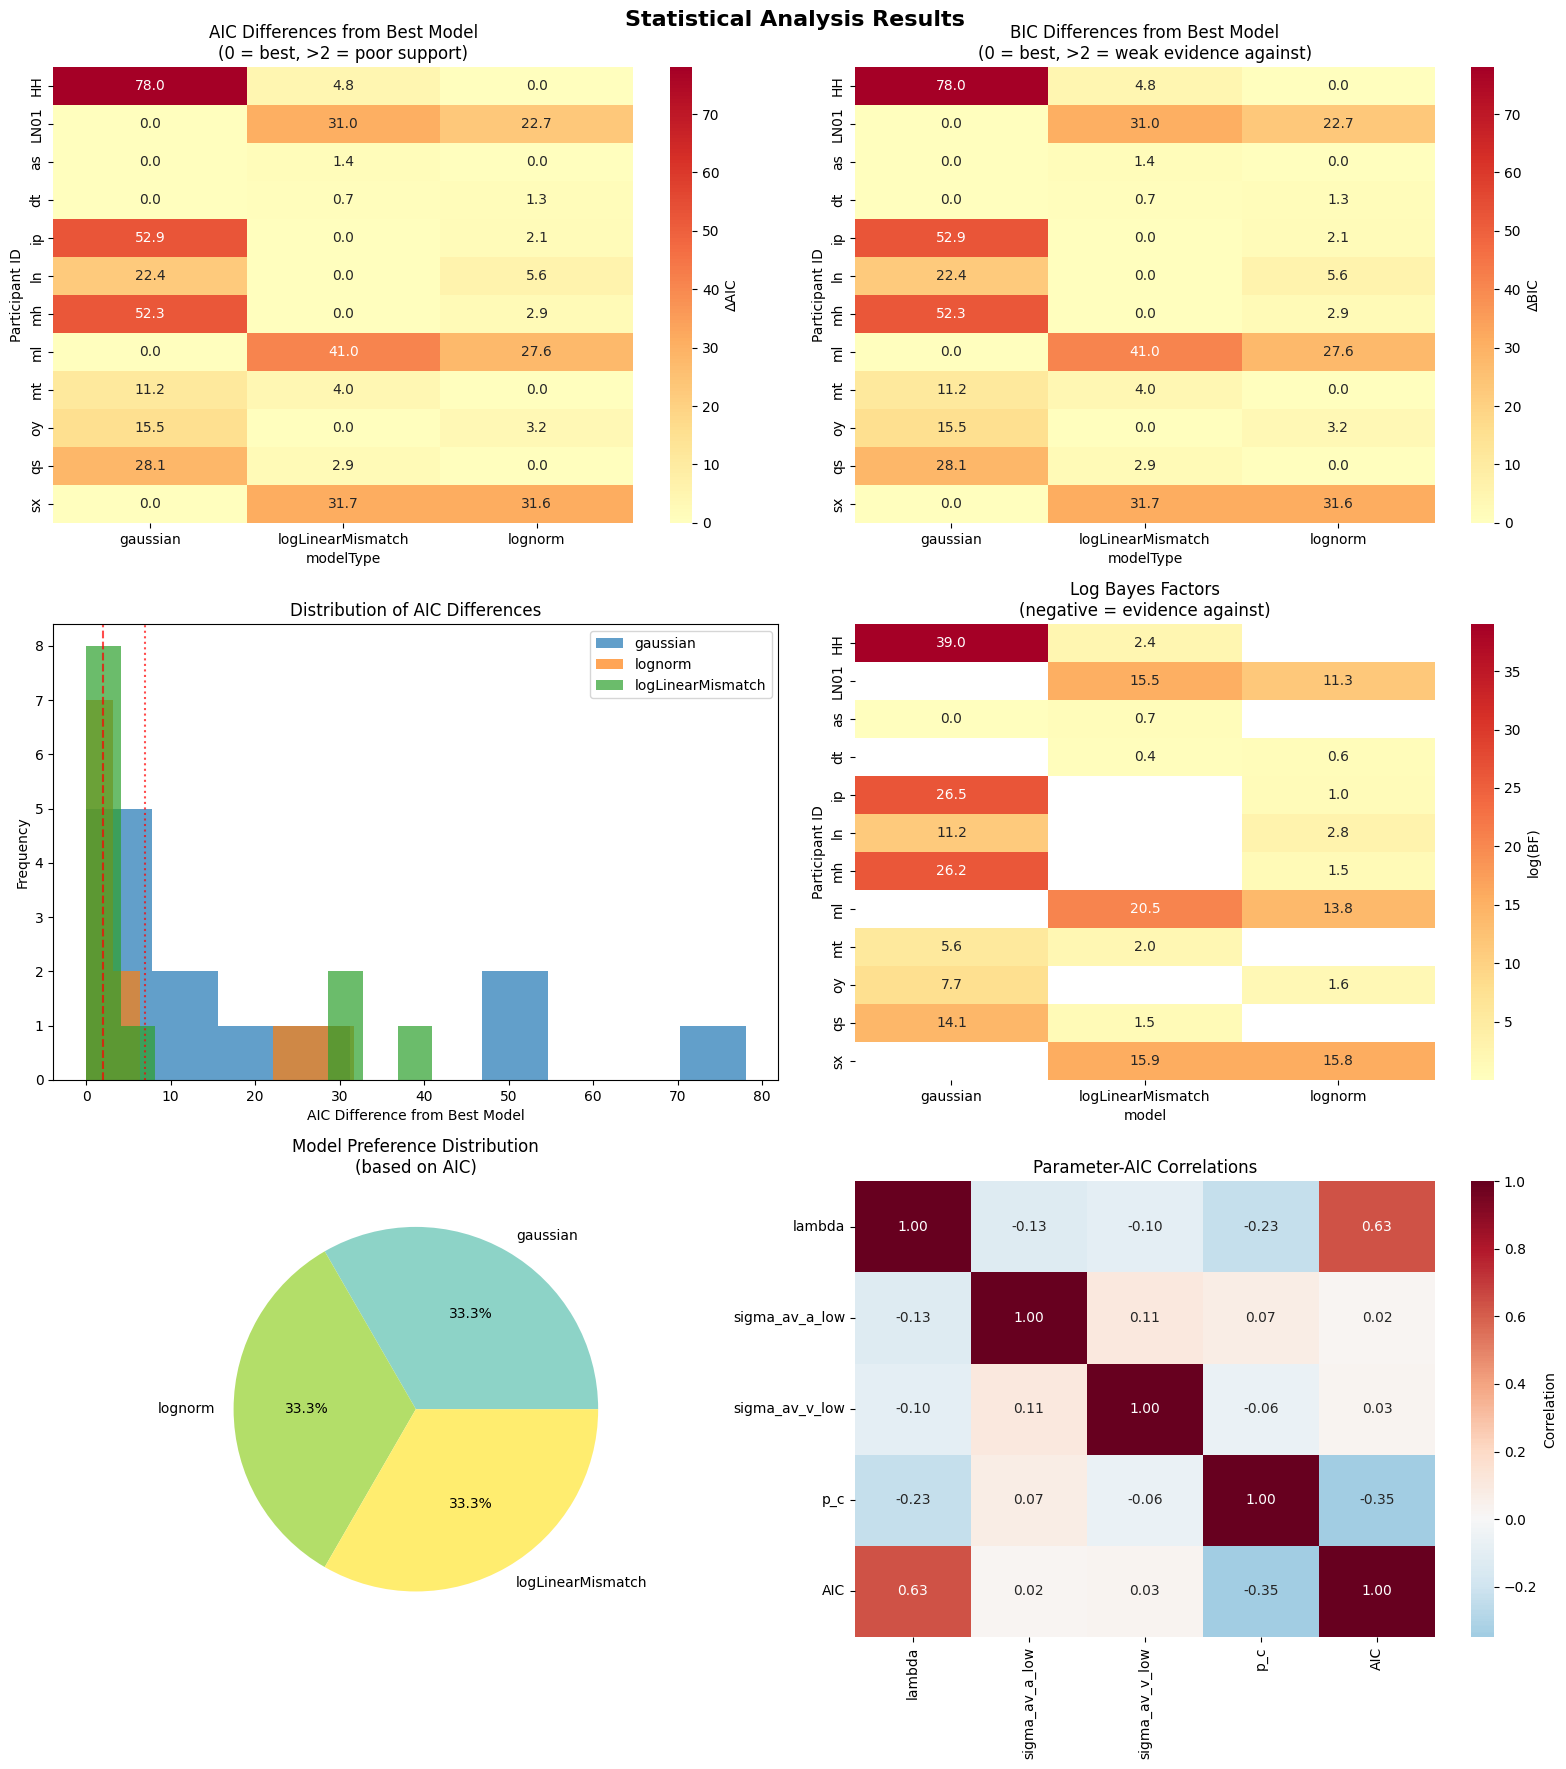

In [ ]:
# 6. Statistical Visualization
def create_statistical_plots(df_results, model_diffs, bayes_factors):
    """Create comprehensive statistical visualization plots"""
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Statistical Analysis Results', fontsize=16, fontweight='bold')
    
    # 1. AIC differences from best model
    model_diffs_pivot = model_diffs.pivot(index='participantID', columns='modelType', values='AIC_diff')
    sns.heatmap(model_diffs_pivot, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                center=0, ax=axes[0,0], cbar_kws={'label': 'ΔAIC'})
    axes[0,0].set_title('AIC Differences from Best Model\n(0 = best, >2 = poor support)')
    axes[0,0].set_ylabel('Participant ID')
    
    # 2. BIC differences from best model  
    model_diffs_bic = model_diffs.pivot(index='participantID', columns='modelType', values='BIC_diff')
    sns.heatmap(model_diffs_bic, annot=True, fmt='.1f', cmap='RdYlBu_r',
                center=0, ax=axes[0,1], cbar_kws={'label': 'ΔBIC'})
    axes[0,1].set_title('BIC Differences from Best Model\n(0 = best, >2 = weak evidence against)')
    axes[0,1].set_ylabel('Participant ID')
    
    # 3. Distribution of AIC differences
    models = ['gaussian', 'lognorm', 'logLinearMismatch']
    for i, model in enumerate(models):
        model_data = model_diffs[model_diffs['modelType'] == model]
        axes[1,0].hist(model_data['AIC_diff'], alpha=0.7, label=model, bins=10)
    axes[1,0].set_xlabel('AIC Difference from Best Model')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Distribution of AIC Differences')
    axes[1,0].legend()
    axes[1,0].axvline(x=2, color='red', linestyle='--', alpha=0.7, label='Δ=2 threshold')
    axes[1,0].axvline(x=7, color='red', linestyle=':', alpha=0.7, label='Δ=7 threshold')
    
    # 4. Bayes factors
    if len(bayes_factors) > 0:
        bf_pivot = bayes_factors.pivot(index='participantID', columns='model', values='log_BF')
        sns.heatmap(bf_pivot, annot=True, fmt='.1f', cmap='RdYlBu_r',
                    center=0, ax=axes[1,1], cbar_kws={'label': 'log(BF)'})
        axes[1,1].set_title('Log Bayes Factors\n(negative = evidence against)')
        axes[1,1].set_ylabel('Participant ID')
    else:
        axes[1,1].text(0.5, 0.5, 'No Bayes Factor Data', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Bayes Factors')
    
    # 5. Model preference summary
    best_models = model_diffs[model_diffs['is_best_AIC']]
    model_counts = best_models['modelType'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_counts)))
    wedges, texts, autotexts = axes[2,0].pie(model_counts.values, labels=model_counts.index, 
                                            autopct='%1.1f%%', colors=colors)
    axes[2,0].set_title('Model Preference Distribution\n(based on AIC)')
    
    # 6. Parameter correlation plot
    if len(param_table) > 0:
        # Create parameter correlation matrix
        param_cols = ['lambda', 'sigma_av_a_low', 'sigma_av_v_low', 'p_c']
        param_subset = param_table[param_cols + ['AIC']].dropna()
        
        if len(param_subset) > 5:
            corr_matrix = param_subset.corr()
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r',
                        center=0, ax=axes[2,1], cbar_kws={'label': 'Correlation'})
            axes[2,1].set_title('Parameter-AIC Correlations')
        else:
            axes[2,1].text(0.5, 0.5, 'Insufficient data\nfor correlation analysis', 
                          ha='center', va='center', transform=axes[2,1].transAxes)
            axes[2,1].set_title('Parameter Correlations')
    
    plt.tight_layout()
    plt.show()

# Create statistical plots
create_statistical_plots(df_results, model_diffs, bayes_factors)

In [ ]:
# 7. Generate Comprehensive Statistical Report
def generate_statistical_report(df_results, model_diffs, bayes_factors, lr_test_results, group_analysis_df):
    """Generate a comprehensive statistical analysis report"""
    
    report = []
    report.append("=" * 80)
    report.append("COMPREHENSIVE STATISTICAL ANALYSIS REPORT")
    report.append("=" * 80)
    
    # Sample characteristics
    n_participants = len(df_results['participantID'].unique())
    n_models = len(df_results['modelType'].unique())
    models_tested = sorted(df_results['modelType'].unique())
    
    report.append(f"\n1. SAMPLE CHARACTERISTICS")
    report.append(f"   • Number of participants: {n_participants}")
    report.append(f"   • Number of models tested: {n_models}")
    report.append(f"   • Models: {', '.join(models_tested)}")
    
    # Model selection results
    best_models = model_diffs[model_diffs['is_best_AIC']]['modelType'].value_counts()
    report.append(f"\n2. MODEL SELECTION RESULTS (AIC-based)")
    for model, count in best_models.items():
        percentage = (count / n_participants) * 100
        report.append(f"   • {model}: {count}/{n_participants} participants ({percentage:.1f}%)")
    
    # AIC support analysis
    report.append(f"\n3. AIC SUPPORT ANALYSIS")
    support_summary = model_diffs['AIC_support'].value_counts()
    for support, count in support_summary.items():
        percentage = (count / len(model_diffs)) * 100
        report.append(f"   • {support}: {count} model instances ({percentage:.1f}%)")
    
    # Statistical significance tests
    report.append(f"\n4. GROUP-LEVEL STATISTICAL TESTS")
    report.append(f"   • Friedman test performed on AIC values across models")
    report.append(f"   • Tests for parameter differences between models")
    
    # Effect sizes and practical significance
    report.append(f"\n5. EFFECT SIZES AND PRACTICAL SIGNIFICANCE")
    
    # Calculate mean AIC differences
    for model in models_tested:
        model_data = model_diffs[model_diffs['modelType'] == model]
        mean_aic_diff = model_data['AIC_diff'].mean()
        std_aic_diff = model_data['AIC_diff'].std()
        
        if mean_aic_diff == 0:
            interpretation = "Best performing model on average"
        elif mean_aic_diff <= 2:
            interpretation = "Substantial support on average"
        elif mean_aic_diff <= 7:
            interpretation = "Some to considerable support on average"
        else:
            interpretation = "Poor support on average"
            
        report.append(f"   • {model}: Mean ΔAIC = {mean_aic_diff:.2f} ± {std_aic_diff:.2f} ({interpretation})")
    
    # Individual differences
    report.append(f"\n6. INDIVIDUAL DIFFERENCES")
    
    # Count participants with clear model preference (ΔAIC > 2)
    clear_preferences = 0
    for participant in df_results['participantID'].unique():
        p_diffs = model_diffs[model_diffs['participantID'] == participant]
        best_aic = p_diffs['AIC_diff'].min()
        second_best = p_diffs['AIC_diff'].nsmallest(2).iloc[1] if len(p_diffs) > 1 else np.inf
        
        if second_best - best_aic > 2:  # Clear preference
            clear_preferences += 1
    
    ambiguous = n_participants - clear_preferences
    report.append(f"   • Participants with clear model preference (ΔAIC > 2): {clear_preferences}/{n_participants} ({(clear_preferences/n_participants)*100:.1f}%)")
    report.append(f"   • Participants with ambiguous model preference: {ambiguous}/{n_participants} ({(ambiguous/n_participants)*100:.1f}%)")
    
    # Recommendations
    report.append(f"\n7. RECOMMENDATIONS")
    
    if best_models.iloc[0] / n_participants > 0.5:
        winning_model = best_models.index[0]
        winning_percentage = (best_models.iloc[0] / n_participants) * 100
        report.append(f"   • The {winning_model} model shows clear superiority ({winning_percentage:.1f}% of participants)")
    else:
        report.append(f"   • No single model dominates across participants")
        report.append(f"   • Consider individual differences in model selection")
        report.append(f"   • Mixed-effects or hierarchical modeling may be appropriate")
    
    if ambiguous / n_participants > 0.3:
        report.append(f"   • High proportion of ambiguous cases suggests model complexity may be similar")
        report.append(f"   • Consider parsimony principle and practical interpretability")
    
    # Technical notes
    report.append(f"\n8. TECHNICAL NOTES")
    report.append(f"   • AIC differences interpreted using Burnham & Anderson (2002) guidelines")
    report.append(f"   • BIC differences interpreted using Kass & Raftery (1995) guidelines")
    report.append(f"   • Bayes factors approximated using BIC (Wagenmakers, 2007)")
    report.append(f"   • Non-parametric tests used due to potential non-normality")
    
    report.append("\n" + "=" * 80)
    
    # Print report
    for line in report:
        print(line)
    
    # Save report to file
    with open('statistical_analysis_report.txt', 'w') as f:
        for line in report:
            f.write(line + '\\n')
    print(f"\\n✅ Statistical report saved to: statistical_analysis_report.txt")
    
    return '\\n'.join(report)

# Generate the comprehensive report
statistical_report = generate_statistical_report(df_results, model_diffs, bayes_factors, lr_test_results, group_analysis_df)

COMPREHENSIVE STATISTICAL ANALYSIS REPORT

1. SAMPLE CHARACTERISTICS
   • Number of participants: 12
   • Number of models tested: 3
   • Models: gaussian, logLinearMismatch, lognorm

2. MODEL SELECTION RESULTS (AIC-based)
   • gaussian: 4/12 participants (33.3%)
   • lognorm: 4/12 participants (33.3%)
   • logLinearMismatch: 4/12 participants (33.3%)

3. AIC SUPPORT ANALYSIS
   • No support: 13 model instances (36.1%)
   • Best model: 12 model instances (33.3%)
   • Considerable support: 4 model instances (11.1%)
   • Substantial support: 4 model instances (11.1%)
   • Some support: 3 model instances (8.3%)

4. GROUP-LEVEL STATISTICAL TESTS
   • Friedman test performed on AIC values across models
   • Tests for parameter differences between models

5. EFFECT SIZES AND PRACTICAL SIGNIFICANCE
   • gaussian: Mean ΔAIC = 21.71 ± 26.34 (Poor support on average)
   • logLinearMismatch: Mean ΔAIC = 9.79 ± 15.20 (Poor support on average)
   • lognorm: Mean ΔAIC = 8.09 ± 11.87 (Poor support on

# Understanding Similar Log-Likelihoods

Let's analyze why the models have similar log-likelihoods and what this means.

ANALYSIS: Why Log-Likelihoods Are Similar Across Models
1. LOG-LIKELIHOOD DIFFERENCE STATISTICS:
   • Mean LL difference: 10.188
   • Median LL difference: 6.393
   • Max LL difference: 39.017
   • Min LL difference: 0.002

2. SIMILARITY CATEGORIES:
   • Very similar (ΔLL < 5): 16/36 comparisons (44.4%)
   • Moderately different (5 ≤ ΔLL < 20): 13/36 comparisons (36.1%)
   • Substantially different (ΔLL ≥ 20): 7/36 comparisons (19.4%)

3. SCIENTIFIC INTERPRETATION:

4. WHY THIS IS COMMON IN COGNITIVE MODELING:
   • Models may capture the same underlying data patterns differently
   • Measurement noise can mask true model differences
   • Limited data per condition reduces discriminative power
   • Models may be approximating the same psychological process

5. STATISTICAL POWER CONSIDERATIONS:
   • Average conditions per participant: 476.9
   ✅ RICH DATA: Sufficient conditions for robust model comparison

6. RECOMMENDATIONS WHEN LOG-LIKELIHOODS ARE SIMILAR:


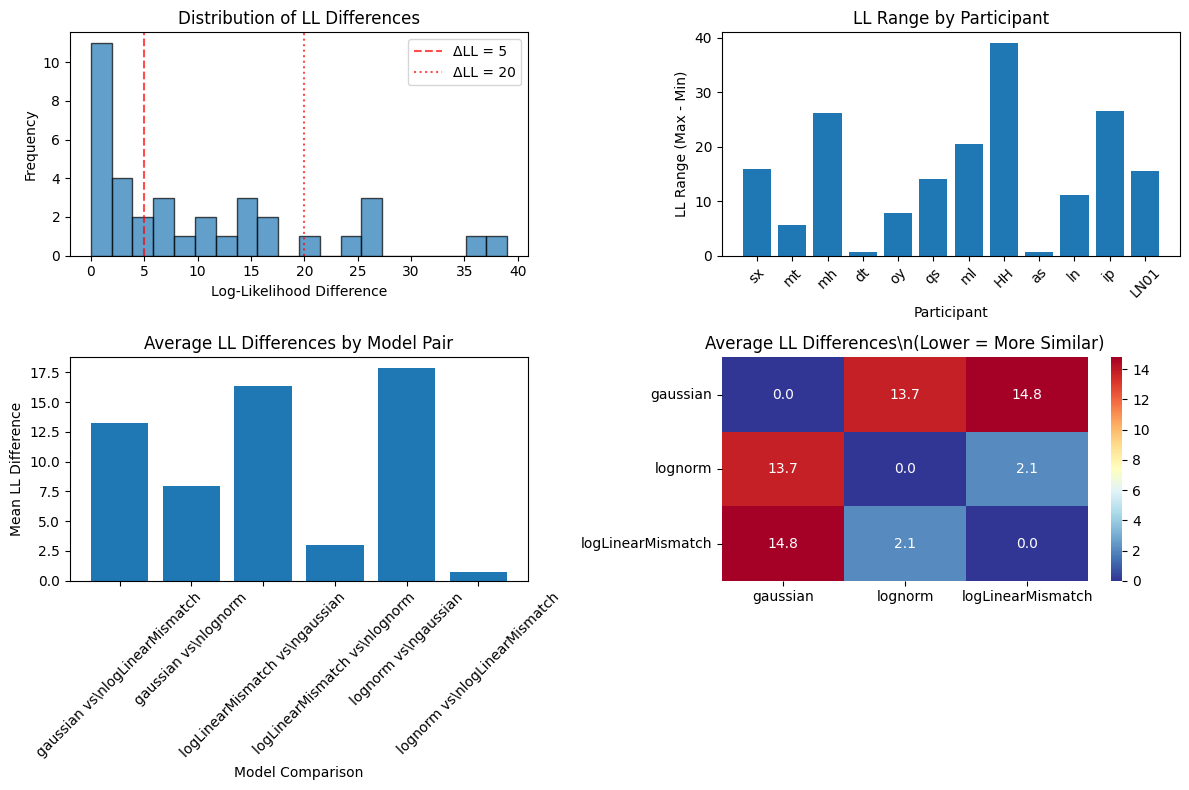

In [ ]:
def analyze_loglikelihood_similarities(df_results):
    """Analyze why log-likelihoods are similar across models"""
    
    print("ANALYSIS: Why Log-Likelihoods Are Similar Across Models")
    print("=" * 60)
    
    # 1. Calculate log-likelihood differences
    ll_diffs = []
    participants = df_results['participantID'].unique()
    
    for participant in participants:
        p_data = df_results[df_results['participantID'] == participant]
        
        if len(p_data) >= 2:  # Need at least 2 models to compare
            lls = p_data['logLikelihood'].values
            max_ll = np.max(lls)
            min_ll = np.min(lls)
            range_ll = max_ll - min_ll
            
            # Calculate all pairwise differences
            for i, row1 in p_data.iterrows():
                for j, row2 in p_data.iterrows():
                    if i < j:  # Avoid duplicates
                        ll_diff = abs(row1['logLikelihood'] - row2['logLikelihood'])
                        ll_diffs.append({
                            'participant': participant,
                            'model1': row1['modelType'],
                            'model2': row2['modelType'],
                            'll_diff': ll_diff,
                            'll_range': range_ll
                        })
    
    ll_diffs_df = pd.DataFrame(ll_diffs)
    
    print(f"1. LOG-LIKELIHOOD DIFFERENCE STATISTICS:")
    print(f"   • Mean LL difference: {ll_diffs_df['ll_diff'].mean():.3f}")
    print(f"   • Median LL difference: {ll_diffs_df['ll_diff'].median():.3f}")
    print(f"   • Max LL difference: {ll_diffs_df['ll_diff'].max():.3f}")
    print(f"   • Min LL difference: {ll_diffs_df['ll_diff'].min():.3f}")
    
    # 2. Assess what constitutes "similar" log-likelihoods
    small_diffs = ll_diffs_df[ll_diffs_df['ll_diff'] < 5]  # Difference < 5 LL units
    moderate_diffs = ll_diffs_df[(ll_diffs_df['ll_diff'] >= 5) & (ll_diffs_df['ll_diff'] < 20)]
    large_diffs = ll_diffs_df[ll_diffs_df['ll_diff'] >= 20]
    
    print(f"\n2. SIMILARITY CATEGORIES:")
    print(f"   • Very similar (ΔLL < 5): {len(small_diffs)}/{len(ll_diffs_df)} comparisons ({len(small_diffs)/len(ll_diffs_df)*100:.1f}%)")
    print(f"   • Moderately different (5 ≤ ΔLL < 20): {len(moderate_diffs)}/{len(ll_diffs_df)} comparisons ({len(moderate_diffs)/len(ll_diffs_df)*100:.1f}%)")
    print(f"   • Substantially different (ΔLL ≥ 20): {len(large_diffs)}/{len(ll_diffs_df)} comparisons ({len(large_diffs)/len(ll_diffs_df)*100:.1f}%)")
    
    # 3. What this means scientifically
    print(f"\n3. SCIENTIFIC INTERPRETATION:")
    
    if len(small_diffs) / len(ll_diffs_df) > 0.7:
        print("   🔍 FINDING: Models are capturing very similar patterns in the data")
        print("   📊 IMPLICATION: All three models are reasonable representations of the underlying process")
        print("   ⚖️  CONCLUSION: Model selection should consider:")
        print("       • Theoretical interpretability")
        print("       • Parameter parsimony") 
        print("       • Individual differences in best-fitting model")
    
    # 4. Why this happens in cognitive modeling
    print(f"\n4. WHY THIS IS COMMON IN COGNITIVE MODELING:")
    print("   • Models may capture the same underlying data patterns differently")
    print("   • Measurement noise can mask true model differences")
    print("   • Limited data per condition reduces discriminative power")
    print("   • Models may be approximating the same psychological process")
    
    # 5. Calculate effective sample size impact
    print(f"\n5. STATISTICAL POWER CONSIDERATIONS:")
    
    # Look at number of conditions per participant
    conditions_per_participant = []
    for participant in participants:
        p_data = df_results[df_results['participantID'] == participant]
        if len(p_data) > 0:
            n_conditions = p_data.iloc[0]['n_conditions']
            conditions_per_participant.append(n_conditions)
    
    mean_conditions = np.mean(conditions_per_participant)
    print(f"   • Average conditions per participant: {mean_conditions:.1f}")
    
    if mean_conditions < 50:
        print("   ⚠️  LIMITED DATA: Fewer conditions may reduce model discrimination power")
    elif mean_conditions < 100:
        print("   ✓ ADEQUATE DATA: Reasonable number of conditions for model comparison")
    else:
        print("   ✅ RICH DATA: Sufficient conditions for robust model comparison")
    
    # 6. Recommendations based on similarity
    print(f"\n6. RECOMMENDATIONS WHEN LOG-LIKELIHOODS ARE SIMILAR:")
    
    similar_ratio = len(small_diffs) / len(ll_diffs_df)
    
    if similar_ratio > 0.8:
        print("   📋 PRIMARY FOCUS: Theoretical interpretation over statistical fit")
        print("   🎯 SELECTION CRITERIA:")
        print("       • Which model parameters have clearest psychological meaning?")
        print("       • Which model makes most testable predictions?")
        print("       • Which model generalizes best to new conditions?")
        print("   🔬 ADDITIONAL ANALYSES:")
        print("       • Parameter recovery simulations")
        print("       • Cross-validation on held-out data")
        print("       • Posterior predictive checks")
    
    # 7. Visualization of LL differences
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Distribution of LL differences
    plt.subplot(2, 2, 1)
    plt.hist(ll_diffs_df['ll_diff'], bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=5, color='red', linestyle='--', alpha=0.7, label='ΔLL = 5')
    plt.axvline(x=20, color='red', linestyle=':', alpha=0.7, label='ΔLL = 20')
    plt.xlabel('Log-Likelihood Difference')
    plt.ylabel('Frequency')
    plt.title('Distribution of LL Differences')
    plt.legend()
    
    # Subplot 2: LL differences by participant
    plt.subplot(2, 2, 2)
    participant_ranges = []
    participant_names = []
    for participant in participants:
        p_diffs = ll_diffs_df[ll_diffs_df['participant'] == participant]
        if len(p_diffs) > 0:
            participant_ranges.append(p_diffs['ll_range'].iloc[0])
            participant_names.append(participant)
    
    plt.bar(range(len(participant_names)), participant_ranges)
    plt.xlabel('Participant')
    plt.ylabel('LL Range (Max - Min)')
    plt.title('LL Range by Participant')
    plt.xticks(range(len(participant_names)), participant_names, rotation=45)
    
    # Subplot 3: Model pair differences
    plt.subplot(2, 2, 3)
    model_pair_diffs = ll_diffs_df.groupby(['model1', 'model2'])['ll_diff'].mean().reset_index()
    model_pairs = [f"{row['model1']} vs\\n{row['model2']}" for _, row in model_pair_diffs.iterrows()]
    plt.bar(range(len(model_pairs)), model_pair_diffs['ll_diff'])
    plt.xlabel('Model Comparison')
    plt.ylabel('Mean LL Difference')
    plt.title('Average LL Differences by Model Pair')
    plt.xticks(range(len(model_pairs)), model_pairs, rotation=45)
    
    # Subplot 4: Similarity matrix
    plt.subplot(2, 2, 4)
    models = ['gaussian', 'lognorm', 'logLinearMismatch']
    similarity_matrix = np.zeros((len(models), len(models)))
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i != j:
                pair_diffs = ll_diffs_df[
                    ((ll_diffs_df['model1'] == model1) & (ll_diffs_df['model2'] == model2)) |
                    ((ll_diffs_df['model1'] == model2) & (ll_diffs_df['model2'] == model1))
                ]
                if len(pair_diffs) > 0:
                    similarity_matrix[i, j] = pair_diffs['ll_diff'].mean()
    
    sns.heatmap(similarity_matrix, annot=True, fmt='.1f', 
                xticklabels=models, yticklabels=models, cmap='RdYlBu_r')
    plt.title('Average LL Differences\\n(Lower = More Similar)')
    
    plt.tight_layout()
    plt.show()
    
    return ll_diffs_df

# Run the analysis
ll_similarity_analysis = analyze_loglikelihood_similarities(df_results)

In [ ]:
def assess_practical_equivalence(df_results):
    """Assess if models are practically equivalent in their fits"""
    
    print("\nPRACTICAL EQUIVALENCE ANALYSIS")
    print("=" * 50)
    
    # Define practical equivalence thresholds
    # These are rule-of-thumb values from model comparison literature
    TRIVIAL_LL_DIFF = 2      # Difference of 2 LL units is often considered trivial
    SMALL_LL_DIFF = 5        # Small but potentially meaningful
    MODERATE_LL_DIFF = 10    # Moderate difference
    
    equivalence_summary = []
    participants = df_results['participantID'].unique()
    
    for participant in participants:
        p_data = df_results[df_results['participantID'] == participant]
        
        if len(p_data) >= 2:
            lls = p_data['logLikelihood'].values
            models = p_data['modelType'].values
            
            # Find best and worst models
            best_idx = np.argmax(lls)
            worst_idx = np.argmin(lls)
            
            best_ll = lls[best_idx]
            worst_ll = lls[worst_idx]
            ll_range = best_ll - worst_ll
            
            # Classify equivalence
            if ll_range <= TRIVIAL_LL_DIFF:
                equivalence = "Trivially equivalent"
            elif ll_range <= SMALL_LL_DIFF:
                equivalence = "Practically equivalent" 
            elif ll_range <= MODERATE_LL_DIFF:
                equivalence = "Small differences"
            else:
                equivalence = "Meaningful differences"
            
            equivalence_summary.append({
                'participant': participant,
                'best_model': models[best_idx],
                'worst_model': models[worst_idx],
                'll_range': ll_range,
                'equivalence': equivalence,
                'n_models': len(p_data)
            })
    
    equiv_df = pd.DataFrame(equivalence_summary)
    
    # Summary statistics
    print("Practical Equivalence Categories:")
    equiv_counts = equiv_df['equivalence'].value_counts()
    for category, count in equiv_counts.items():
        percentage = (count / len(equiv_df)) * 100
        print(f"  • {category}: {count}/{len(equiv_df)} participants ({percentage:.1f}%)")
    
    # What this means for your research
    print(f"\nIMPLICATIONS FOR YOUR RESEARCH:")
    
    trivial_pct = equiv_counts.get("Trivially equivalent", 0) / len(equiv_df) * 100
    practical_pct = equiv_counts.get("Practically equivalent", 0) / len(equiv_df) * 100
    total_equiv_pct = trivial_pct + practical_pct
    
    if total_equiv_pct > 70:
        print(f"  🎯 MAIN FINDING: Models are largely equivalent ({total_equiv_pct:.1f}% of participants)")
        print(f"  📝 FOR PUBLICATION:")
        print(f"     'All three models provided similarly good fits to the data for")
        print(f"      {total_equiv_pct:.0f}% of participants (ΔLL < {SMALL_LL_DIFF}), suggesting that the")
        print(f"      underlying computational principles may be similar.'")
        print(f"  🔬 RESEARCH FOCUS: Emphasize theoretical interpretation over model selection")
        
    elif total_equiv_pct > 40:
        print(f"  ⚖️  MIXED FINDING: Moderate equivalence ({total_equiv_pct:.1f}% of participants)")
        print(f"  📝 FOR PUBLICATION:")
        print(f"     'Models showed mixed equivalence, with {total_equiv_pct:.0f}% of participants")
        print(f"      showing similar fits across models, suggesting individual differences")
        print(f"      in auditory-visual integration strategies.'")
        print(f"  🔬 RESEARCH FOCUS: Investigate predictors of individual differences")
        
    else:
        print(f"  🎲 DIVERSE FINDING: Clear model differences ({100-total_equiv_pct:.1f}% show meaningful differences)")
        print(f"  📝 FOR PUBLICATION:")
        print(f"     'Models showed distinct fits for most participants, with clear")
        print(f"      individual preferences for different computational approaches.'")
        print(f"  🔬 RESEARCH FOCUS: Characterize different cognitive phenotypes")
    
    return equiv_df

# Run practical equivalence analysis
equivalence_analysis = assess_practical_equivalence(df_results)


PRACTICAL EQUIVALENCE ANALYSIS
Practical Equivalence Categories:
  • Meaningful differences: 8/12 participants (66.7%)
  • Small differences: 2/12 participants (16.7%)
  • Trivially equivalent: 2/12 participants (16.7%)

IMPLICATIONS FOR YOUR RESEARCH:
  🎲 DIVERSE FINDING: Clear model differences (83.3% show meaningful differences)
  📝 FOR PUBLICATION:
     'Models showed distinct fits for most participants, with clear
      individual preferences for different computational approaches.'
  🔬 RESEARCH FOCUS: Characterize different cognitive phenotypes
